# Modelagem de Tópicos

São poucas as quantidades de modelos que podemos aplicar na maneira que os nossos dados se encontram neste exato momento. Com isso, para que tenhamos mais variáveis quantitativas que ajudam na análise, o intuito é dividir os tweets da família Bolsonaro em tópicos.

In [ ]:
from sklearn.feature_extraction import text 
import pandas as pd
import numpy as np
import re
import string
import unicodedata
import scipy.sparse
import nltk
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from googletrans import Translator
import textblob
from gensim import matutils, models

Como vamos usar diversos recursos do nltk, vale a pena baixar todo seu conteúdo (uma aba vai abrir e é só clicar em baixar tudo):

In [ ]:
#nltk.download()

## Gerando a Document Term Matrix

Usando as stop words em português obtidas no site https://gist.github.com/alopes/5358189, podemos limpar nossos textos dos tweets de modo a transformá-los em uma Document Term Matrix.

In [ ]:
dfOri = pd.read_csv("..//data//tweets//preprocessed_tweets.csv", sep = "~")
tweeys_data = dfOri.drop(columns=['Unnamed: 0'])
tweeys_data["date"] = pd.to_datetime(tweeys_data["date"])
tweeys_data.set_index("date", inplace=True)
tweeys_data.head()

,full_text,hashtags,user_mentions,media_type,status_reply,name,retweet_count,favorite_count,year,month,day,hour,minute,weekday,has_hashtags,has_mentions,has_media
date,,,,,,,,,,,,,,,,,
2020-07-27 20:51:13+00:00,"-Edifício Joelma/SP, 1974.\n\n-Sgt CASSANIGA s...",None,None,video,0,jairbolsonaro,3154,16202,2020,7,27,20,51,0,0,0,1
2020-07-27 11:10:36+00:00,- Água para quem tem sede.\n- Liberdade para u...,None,None,video,0,jairbolsonaro,8101,37357,2020,7,27,11,10,0,0,0,1
2020-07-26 20:18:19+00:00,"@tarcisiogdf @MInfraestrutura 🤝🇧🇷, Ministro!",None,tarcisiogdf/MInfraestrutura,NaN,1,jairbolsonaro,1074,16840,2020,7,26,20,18,6,0,1,1
2020-07-26 15:40:39+00:00,2- @MinEconomia @MinCidadania @onyxlorenzoni @...,None,MinEconomia/MinCidadania/onyxlorenzoni/MEC_Com...,photo,1,jairbolsonaro,1337,6383,2020,7,26,15,40,6,0,1,1
2020-07-26 15:39:47+00:00,1- Acompanhe as redes sociais! @secomvc @fabio...,None,secomvc/fabiofaria5555/tarcisiogdf/MInfraestru...,photo,0,jairbolsonaro,3287,14836,2020,7,26,15,39,6,0,1,1


In [ ]:
pd.set_option('max_colwidth',150)
initial_data = pd.DataFrame(tweeys_data['full_text'].values,index=range(0,len(tweeys_data)),columns=['text'])
initial_data.head()

,text
0,"-Edifício Joelma/SP, 1974.\n\n-Sgt CASSANIGA salta de helicóptero da FAB no terraço do edifício em chamas para salvar vidas, em uma das maiores tr..."
1,"- Água para quem tem sede.\n- Liberdade para um povo. \n- Brasil acima de tudo, Deus acima de todos!\n- BOM DIA.\n\n. YouTube: https://t.co/eS5aHQ..."
2,"@tarcisiogdf @MInfraestrutura 🤝🇧🇷, Ministro!"
3,2- @MinEconomia @MinCidadania @onyxlorenzoni @MEC_Comunicacao @ItamaratyGovBr @ernestofaraujo https://t.co/WVf6V7pqzC
4,1- Acompanhe as redes sociais! @secomvc @fabiofaria5555 @tarcisiogdf @MInfraestrutura @MinEconomia @minsaude @Mapa_Brasil @TerezaCrisMS @DHumanosB...


Limpando um pouco nosso texto de cada tweet:

In [ ]:
def clean_text(text):
    text = text.lower() # texto minúsculo
    text = re.sub('[^A-zÀ-ú0-9 ]', '', text) # manter alfanuméricos e espaço
    #text = re.sub('\w*\d\w*', '', text) # remover qualquer palavra que contenha numeros
    text = re.sub('\w*https?\w*', '', text) # remover urls
    text = ''.join(ch for ch in unicodedata.normalize('NFKD', text) 
        if not unicodedata.combining(ch))   # remover acentos
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remover pontuações esquisitas
    return text

clean_data = pd.DataFrame(initial_data.text.apply(lambda x: clean_text(x)))
clean_data.head()

,text
0,edificio joelmasp 1974sgt cassaniga salta de helicoptero da fab no terraco do edificio em chamas para salvar vidas em uma das maiores tragedias na...
1,agua para quem tem sede liberdade para um povo brasil acima de tudo deus acima de todos bom dia youtube
2,tarcisiogdf minfraestrutura ministro
3,2 mineconomia mincidadania onyxlorenzoni meccomunicacao itamaratygovbr ernestofaraujo
4,1 acompanhe as redes sociais secomvc fabiofaria5555 tarcisiogdf minfraestrutura mineconomia minsaude mapabrasil terezacrisms dhumanosbrasil damare...


Criando a Document Term Matrix:

In [ ]:
pt_stop_words = np.array([])
# stopwords.txt é o arquivo que se encontra no link no começo da subseção
with open("..//data//tweets//stopwords.txt",encoding="utf-8") as file:
    line = file.readline()
    while line != '':
        line = re.sub('\\n$| $', '', line)
        pt_stop_words = np.append(pt_stop_words,line)
        line = file.readline()
pt_stop_words = [clean_text(pt_stop_words[i]) for i in range(0,len(pt_stop_words))]
pt_stop_words = list(set(pt_stop_words))

cv = text.CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(pt_stop_words))
data_cv = cv.fit_transform(clean_data.values.ravel())
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = clean_data.index
tdm = data_dtm.transpose()
tdm.head()

,0,1,2,3,4,5,6,7,8,9,...,12824,12825,12826,12827,12828,12829,12830,12831,12832,12833
0001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00h30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Aplicando Topic Modelling (tentativa 1)

Com a nossa Document Term Matrix (transposta devido à entrada da função a seguir), podemos usar a biblioteca Gensim para criar um modelo de Latent Dirichlet Allocation (LDA) e obter os nossos resultados.

In [ ]:
# Colocando a Term Document Matrix em um novo formato gensim, de df --> sparse matrix --> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [ ]:
# Gensim também precisa de um dicionário com todos os termos e suas respectivas posições na Term Document Matrix
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

Agora que temos o corpus (Term Document Matrix) e o id2word (dicionário de localização: termo), precisamos especificar dois outros parâmetros - o número de tópicos e o número de passos. Inicialmente vamos testar com $4$, $6$ e $10$ tópicos juntamente com $10$ passos e ver se os resultados fazem sentido.

In [ ]:
# Agora que já temos o corpus (Term Document Matrix) e id2word (dicionário de localização: termo),
# precisamos especificar também dois outros parâmetros - o número de tópicos e de passos
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10, random_state=42)
lda.print_topics()

[(0,
  '0.020*"rt" + 0.009*"bolsonaro" + 0.008*"presidente" + 0.007*"brasil" + 0.006*"bolsonarosp" + 0.006*"jairbolsonaro" + 0.006*"tudo" + 0.005*"todos" + 0.005*"sempre" + 0.005*"contra"'),
 (1,
  '0.015*"brasil" + 0.010*"governo" + 0.008*"bolsonaro" + 0.006*"ano" + 0.006*"2019" + 0.005*"rt" + 0.005*"maior" + 0.005*"pais" + 0.004*"economia" + 0.004*"empregos"'),
 (2,
  '0.012*"governo" + 0.010*"milhoes" + 0.008*"rt" + 0.006*"mil" + 0.006*"saude" + 0.006*"jairbolsonaro" + 0.005*"govbr" + 0.005*"bolsonaro" + 0.005*"mdregionalbr" + 0.005*"federal"'),
 (3,
  '0.010*"rt" + 0.009*"jairbolsonaro" + 0.007*"presidente" + 0.006*"bolsonaro" + 0.005*"parabens" + 0.005*"abraco" + 0.005*"rio" + 0.004*"brasil" + 0.004*"pt" + 0.004*"dia"')]

In [ ]:
lda2 = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=6, passes=10, random_state=42)
lda2.print_topics()

[(0,
  '0.028*"rt" + 0.011*"bolsonaro" + 0.011*"presidente" + 0.010*"jairbolsonaro" + 0.010*"bolsonarosp" + 0.007*"contra" + 0.007*"sobre" + 0.007*"tudo" + 0.006*"deus" + 0.006*"todos"'),
 (1,
  '0.019*"brasil" + 0.011*"governo" + 0.009*"bolsonaro" + 0.007*"2019" + 0.007*"ano" + 0.006*"maior" + 0.006*"pais" + 0.006*"economia" + 0.005*"bilhoes" + 0.005*"empregos"'),
 (2,
  '0.010*"rt" + 0.006*"jairbolsonaro" + 0.006*"governo" + 0.004*"presidente" + 0.004*"brasil" + 0.004*"parte" + 0.004*"sabemos" + 0.003*"sempre" + 0.003*"contra" + 0.003*"midia"'),
 (3,
  '0.008*"rt" + 0.008*"jairbolsonaro" + 0.008*"bolsonaro" + 0.007*"brasil" + 0.007*"todos" + 0.007*"presidente" + 0.007*"dia" + 0.006*"abraco" + 0.006*"hoje" + 0.006*"parabens"'),
 (4,
  '0.009*"rt" + 0.007*"bolsonaro" + 0.006*"dinheiro" + 0.005*"presidente" + 0.004*"governo" + 0.004*"brasil" + 0.004*"alguem" + 0.004*"jairbolsonaro" + 0.003*"publico" + 0.003*"prudencia"'),
 (5,
  '0.015*"governo" + 0.012*"milhoes" + 0.009*"mil" + 0.007*"

In [ ]:
lda3 = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, passes=10, random_state=42)
lda3.print_topics()

[(0,
  '0.029*"rt" + 0.015*"bolsonaro" + 0.015*"presidente" + 0.011*"brasil" + 0.010*"todos" + 0.010*"jairbolsonaro" + 0.009*"tudo" + 0.009*"contra" + 0.008*"sobre" + 0.008*"sempre"'),
 (1,
  '0.030*"brasil" + 0.009*"rio" + 0.007*"mercado" + 0.006*"desenvolvimento" + 0.006*"pais" + 0.006*"pai" + 0.005*"economia" + 0.005*"grande" + 0.005*"pode" + 0.005*"janeiro"'),
 (2,
  '0.015*"rt" + 0.013*"arthurweint" + 0.007*"governo" + 0.006*"politicos" + 0.006*"disse" + 0.006*"congresso" + 0.006*"familia" + 0.005*"justica" + 0.005*"jairbolsonaro" + 0.005*"poder"'),
 (3,
  '0.014*"minfraestrutura" + 0.013*"tarcisiogdf" + 0.009*"obras" + 0.009*"rt" + 0.006*"jairbolsonaro" + 0.005*"legal" + 0.005*"somente" + 0.004*"trabalho" + 0.004*"governo" + 0.004*"nova"'),
 (4,
  '0.024*"bolsonaro" + 0.015*"rt" + 0.008*"jair" + 0.008*"presidente" + 0.008*"fake" + 0.007*"conexaopolitica" + 0.007*"news" + 0.007*"jairbolsonaro" + 0.005*"brasil" + 0.005*"tentativa"'),
 (5,
  '0.016*"youtube" + 0.014*"jairbolsonaro" 

Os resultados são interessantes, mas ainda confusos devido a algumas outras stop words e palavras. Realizaremos a mesma análise agora deixando apenas substantivos e adjetivos (e removendo algumas stop words extras).

## Aplicando Topic Modelling (tentativa 2)

Para que o nosso modelo se torne mais preciso para nossos objetivos, podemos adicionar algumas stop_words identificadas nos grupos de tópicos acima e também filtrar nossas palavras para apenas substantivos e adjetivos.

In [ ]:
# Algumas stop words comuns nos tweets
add_stop_words = ['pra','ai','rt', 'fazem', 'aqui', 'entao', 'vamos', 'vai', 'onde','somente','apos','cara','tipo']

# Função que retorna substantivo e adjetivo
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = nltk.word_tokenize(text,language='portuguese')
    nouns_adj = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

nouns_adj_data = pd.DataFrame(clean_data.text.apply(lambda x: nouns_adj(x)))
nouns_adj_data.head()

,text
0,edificio joelmasp cassaniga salta da fab terraco chamas para salvar uma das maiores historia youtube
1,agua para quem tem sede para um povo brasil acima deus acima bom dia youtube
2,tarcisiogdf minfraestrutura ministro
3,mineconomia mincidadania onyxlorenzoni meccomunicacao itamaratygovbr ernestofaraujo
4,acompanhe redes secomvc fabiofaria5555 tarcisiogdf minfraestrutura mineconomia mapabrasil terezacrisms damaresalves


In [ ]:
cv_new = text.CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(pt_stop_words+add_stop_words))
data_cv_new = cv_new.fit_transform(nouns_adj_data.values.ravel())
data_dtm_new = pd.DataFrame(data_cv_new.toarray(), columns=cv_new.get_feature_names())
data_dtm_new.index = nouns_adj_data.index
tdm_new = data_dtm_new.transpose()
sparse_counts_new = scipy.sparse.csr_matrix(tdm_new)

# Criando o corpus do Gensim
corpus_new = matutils.Sparse2Corpus(sparse_counts_new)

# Create the vocabulary dictionary
id2word_new = dict((v, k) for k, v in cv_new.vocabulary_.items())

In [ ]:
# Teste com 10 tópicos
lda6 = models.LdaModel(corpus=corpus_new, num_topics=10, id2word=id2word_new, passes=20, random_state=42)
lda6.print_topics()

[(0,
  '0.025*"brasil" + 0.017*"todos" + 0.015*"deus" + 0.013*"tudo" + 0.010*"presidente" + 0.008*"povo" + 0.008*"jairbolsonaro" + 0.007*"sempre" + 0.007*"quer" + 0.006*"bem"'),
 (1,
  '0.013*"governo" + 0.010*"mineconomia" + 0.010*"bilhoes" + 0.009*"brasil" + 0.008*"bolsonaro" + 0.008*"programa" + 0.007*"mil" + 0.007*"economia" + 0.007*"anos" + 0.007*"maior"'),
 (2,
  '0.022*"milhoes" + 0.015*"mil" + 0.011*"combate" + 0.011*"covid19" + 0.011*"acoes" + 0.010*"federal" + 0.009*"lula" + 0.008*"estados" + 0.007*"jairbolsonaro" + 0.007*"governo"'),
 (3,
  '0.011*"bolsonarosp" + 0.010*"ainda" + 0.010*"bolsonaro" + 0.009*"jairbolsonaro" + 0.009*"sobre" + 0.007*"governo" + 0.007*"trabalho" + 0.007*"tarcisiogdf" + 0.006*"dia" + 0.006*"alguem"'),
 (4,
  '0.018*"governo" + 0.013*"mdregionalbr" + 0.012*"milhoes" + 0.009*"govbr" + 0.008*"bolsonaro" + 0.008*"jairbolsonaro" + 0.008*"semana" + 0.007*"minfraestrutura" + 0.007*"municipios" + 0.006*"detalhes"'),
 (5,
  '0.014*"verdade" + 0.011*"news" + 

Como podemos ver, os assuntos principais dos tweets de cada grupo de tópicos se envolvem em torno de:

0. Religião;
1. Economia; 
2. Pandemia e Esquerda;
3. Trabalho e Infraestrutura;
4. Desenvolvimento Regional e Infraestrutura;
5. Fake News;
6. Acessoria e Agricultura;
7. Rio de Janeiro;
8. Educação;
9. Mídia;

Claro que todas essas afirmações acima são completamente qualitativas.

Criando o vetor de tópicos para adicionarmos aos dados (considerando como o tópico correto o com maior peso):

In [ ]:
corpus_transformed = lda6[corpus_new]
topics = []
for tweetTopics in corpus_transformed:
    maxValue = 0
    rightTopic = 0
    for topic,value in tweetTopics:
        if(value>maxValue):
            maxValue = value
            rightTopic = topic
    topics.append(rightTopic)
topics = np.array(topics)
# Os dados em si serão adicionados após a análise de sentimentos

# Análise de sentimentos

Para obter informações dos tweets coletados iremos efetuar uma anális de sentimentos no tweets, isto é, para cada um dos tweets desejamos indentificar se o texto possui um sentimento positivo ou negativo associado, e além disso, também seremos capazes de avaliar se o texto representa uma opinião ou um fato. Para a análise de sentimentos utilizaremos a biblioteca __Textblob__. No entanto, uma das limitações muitas vezes encontradas para fazer processamento de textos é que a maior parte das ferramentas dão suporte apenas para o inglês, por esse motivo, iremos traduzir cada um dos tweets para inglês utilizando a biblioteca __Googletrans__.

## Tradução e análise de sentimentos

In [ ]:
dfSent = dfOri.drop(columns = ["Unnamed: 0"])
trans = lambda tw : translator.translate(tw).text
full_text_en = []
for i in tqdm(range(0, 12000, 1000)):
    translator = Translator()
    for tw in dfSent.full_text[i:i+1000]:
        full_text_en.append(trans(tw))
for tw in dfSent.full_text[12000:]:
    full_text_en.append(trans(tw))
dfSent["full_text_en"] = full_text_en
pol = lambda x : textblob.TextBlob(x).polarity
sub = lambda x : textblob.TextBlob(x).subjectivity
dfSent['polarity'] = dfSent.full_text_en.apply(pol)
dfSent['subjectivity'] = dfSent.full_text_en.apply(sub)
dfSent.to_pickle('..//data//tweets//sentiment_analysis.pkl')

In [ ]:
# Adicionando os tópicos e exportando os dados
dfSent['topic'] = topics
dfSent.to_pickle("..//data//tweets//final_tweets_data.pkl")

O código acima demora bastante para rodar devido à quantidade de traduções. Com isso, o código abaixo serve para carregar esses dados.

In [ ]:
dfSent = pd.read_pickle('..//data//tweets//sentiment_analysis.pkl')
dfFinal = pd.read_pickle('..//data//tweets//final_tweets_data.pkl')

In [ ]:
dfFinal

,full_text,hashtags,user_mentions,media_type,status_reply,name,retweet_count,favorite_count,date,year,...,hour,minute,weekday,has_hashtags,has_mentions,has_media,full_text_en,polarity,subjectivity,topic
0,"-Edifício Joelma/SP, 1974.\n\n-Sgt CASSANIGA s...",None,None,video,0,jairbolsonaro,3154,16202,2020-07-27 20:51:13+00:00,2020,...,20,51,0,0,0,1,"- Joelma / SP Building, 1974.\n\n-Sgt CASSANIG...",1.000000,1.000000,8
1,- Água para quem tem sede.\n- Liberdade para u...,None,None,video,0,jairbolsonaro,8101,37357,2020-07-27 11:10:36+00:00,2020,...,11,10,0,0,0,1,- Water for those who are thirsty.\n- Freedom ...,0.233333,0.266667,0
2,"@tarcisiogdf @MInfraestrutura 🤝🇧🇷, Ministro!",None,tarcisiogdf/MInfraestrutura,NaN,1,jairbolsonaro,1074,16840,2020-07-26 20:18:19+00:00,2020,...,20,18,6,0,1,1,"@tarcisiogdf @MInfraestrutura 🤝🇧🇷, Minister!",0.000000,0.000000,3
3,2- @MinEconomia @MinCidadania @onyxlorenzoni @...,None,MinEconomia/MinCidadania/onyxlorenzoni/MEC_Com...,photo,1,jairbolsonaro,1337,6383,2020-07-26 15:40:39+00:00,2020,...,15,40,6,0,1,1,2- @MinEconomia @MinCidadania @onyxlorenzoni @...,0.000000,0.000000,1
4,1- Acompanhe as redes sociais! @secomvc @fabio...,None,secomvc/fabiofaria5555/tarcisiogdf/MInfraestru...,photo,0,jairbolsonaro,3287,14836,2020-07-26 15:39:47+00:00,2020,...,15,39,6,0,1,1,1- Follow the social networks! @secomvc @ fabi...,0.041667,0.066667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12829,BRASIL: uma nova abordagem do nosso país para ...,None,None,NaN,0,carlosbolsonaro,1213,7118,2019-08-19 23:00:52+00:00,2019,...,23,0,0,0,0,1,BRASIL: uma nova abordagem do nosso país para ...,0.000000,0.000000,5
12830,NÃO ME DIGA?! rsrsrs... https://t.co/ru5r4Bd4eF,None,None,NaN,0,carlosbolsonaro,1461,10529,2019-08-19 20:35:26+00:00,2019,...,20,35,0,0,0,1,DO NOT TELL ME?! lol ... https://t.co/ru5r4Bd4eF,0.800000,0.700000,8
12831,Alguns gastos de dinheiro público facilitado p...,None,None,photo,0,carlosbolsonaro,1813,6240,2019-08-19 20:21:22+00:00,2019,...,20,21,0,0,0,1,Some spending of public money facilitated for ...,0.209821,0.359524,9
12832,RT @Dom_Andolini: Boneco da Dilma custou mais ...,SouJBeAcabou,Dom_Andolini,video,0,carlosbolsonaro,1761,0,2019-08-19 19:42:08+00:00,2019,...,19,42,0,1,1,1,RT @Dom_Andolini: Boneco da Dilma custou mais ...,0.000000,0.000000,2


Com os dados já traduzidos, vamos observar alguns tweets em português e em inglês para verificar se as traduções são satisfatórias.

In [ ]:
for i in range(5):
    print("Português:")
    print(dfSent.full_text[i])
    print()
    print("Inglês")
    print("\t" + dfSent.full_text_en[i])
    print()

Português:
-Edifício Joelma/SP, 1974.

-Sgt CASSANIGA salta de helicóptero da FAB no terraço do edifício em chamas para salvar vidas, em uma das maiores tragédias na história do Brasil.

. Link no YouTube: https://t.co/JW8q4qN3a8 https://t.co/3Ulw3G96D5

Inglês
	- Joelma / SP Building, 1974.

-Sgt CASSANIGA jumps from the FAB helicopter on the terrace of the burning building to save lives, in one of the greatest tragedies in the history of Brazil.

. Link on YouTube: https://t.co/JW8q4qN3a8 https://t.co/3Ulw3G96D5

Português:
- Água para quem tem sede.
- Liberdade para um povo. 
- Brasil acima de tudo, Deus acima de todos!
- BOM DIA.

. YouTube: https://t.co/eS5aHQfMXu https://t.co/UERpWo4NbR

Inglês
	- Water for those who are thirsty.
- Freedom for a people.
- Brazil above all, God above all!
- GOOD MORNING.

. YouTube: https://t.co/eS5aHQfMXu https://t.co/UERpWo4NbR

Português:
@tarcisiogdf @MInfraestrutura 🤝🇧🇷, Ministro!

Inglês
	@tarcisiogdf @MInfraestrutura 🤝🇧🇷, Minister!

Portugu

# Visualização dos resultados
## Modelagem de Tópicos

Para que a análise gráfica fique mais interessante, podemos converter os tópicos de números para nomes:

In [ ]:
topicsContext = {0:['Religião'],
                1:['Economia'],
                2:['Pandemia','Esquerda'],
                3:['Trabalho','Infraestrutura'],
                4:['Desenvolvimento Regional','Infraestrutura'],
                5:['Fake News'],
                6:['Acessoria','Agricultura'],
                7:['Rio de Janeiro'],
                8:['Educação'],
                9:['Mídia']}

topic_data = dfFinal.groupby(['name','topic']).agg({'topic':len,
                                                   'retweet_count':np.mean,})
topic_data.columns = ['number_tweets','retweet_mean']
topic_data.reset_index(level=['topic','name'],inplace=True)

# mudar de topico:conteudos para conteudo:topicos
contextTopics = {}
for topic,contexts in topicsContext.items():
    for context in contexts:
        if context in contextTopics.keys(): contextTopics[context].append(topic)
        else: contextTopics[context] = [topic]
            
nameList = ['bolsonarosp', 'carlosbolsonaro', 'flaviobolsonaro','jairbolsonaro']
newDf = []
for name in nameList:
    for context in contextTopics.keys():
        total_tweets = 0        
        for topic in contextTopics[context]:
            total_tweets += int(topic_data.iloc[(topic_data['name'].values==name) & (topic_data['topic'].values==topic),2].values)
        newDf.append([name,context,total_tweets])
newDf = pd.DataFrame(newDf,columns=['name','subject','numer_tweets'])
newDf.head()

,name,subject,numer_tweets
0,bolsonarosp,Religião,519
1,bolsonarosp,Economia,280
2,bolsonarosp,Pandemia,136
3,bolsonarosp,Esquerda,136
4,bolsonarosp,Trabalho,483


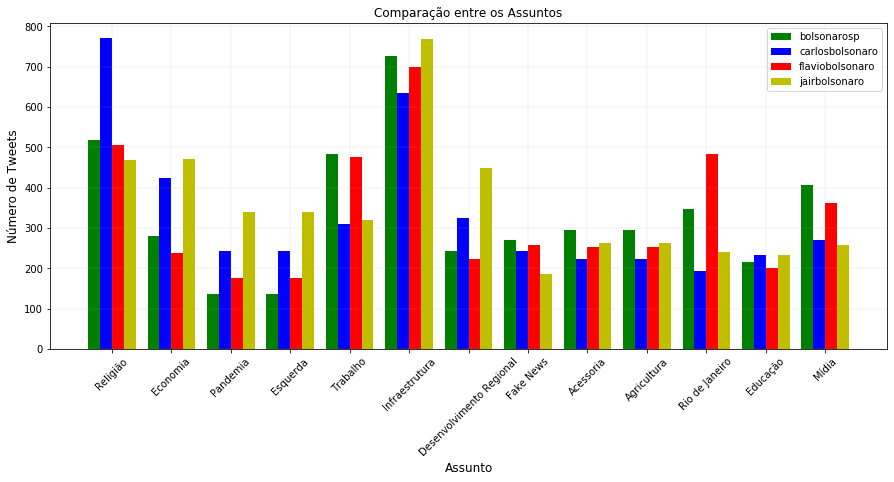

In [ ]:
nameList = ['bolsonarosp', 'carlosbolsonaro', 'flaviobolsonaro','jairbolsonaro']
colors = ['g','b','r','y']
x = np.array(range(0,len(np.unique(newDf.subject.values))))
widthBar = 0.8*np.min(np.diff(x))/len(nameList)

fig, ax = plt.subplots(1,1, figsize=(15,6))

for i in range(0,len(nameList)):
    ax.bar(x-((len(nameList)-1)/2-i)*widthBar,
           newDf.iloc[newDf['name'].values==nameList[i],2].values,
           width = widthBar,
           label=nameList[i],
           color = colors[i])
    
plt.xticks(rotation=45)

ax.set_xlabel("Assunto", fontsize=12)
ax.set_ylabel("Número de Tweets", fontsize=12)
ax.set_title('Comparação entre os Assuntos', fontsize=12)
plt.xticks(x, newDf.subject.values[0:13])
ax.grid(True, lw=1.5, ls='-', alpha=0.1)
ax.legend()
plt.savefig('..//images//topic_dist.pdf')
plt.show()

Podemos ver que os tweets estão semelhantemente distribuídos pelos assuntos, com discrepâncias como Carlos Bolsonaro com relação ao tema religião, Flávio Bolsonaro com o tema Rio de Janeiro e Jair Bolsonaro com o tema Desenvolvimento Regional. 

## Análise de Sentimentos

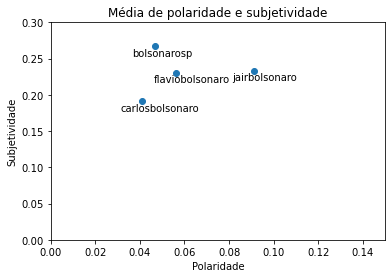

In [ ]:
plot_data = dfSent.groupby(by = "name").mean()
plt.scatter(plot_data.polarity, plot_data.subjectivity)
plt.title("Média de polaridade e subjetividade")
for row in range(len(plot_data)):
    plt.annotate(plot_data.index[row], (plot_data.polarity[row] - 0.01, plot_data.subjectivity[row] - 0.013))
plt.xlabel("Polaridade")
plt.ylabel("Subjetividade")
plt.xlim([0, 0.15])
plt.ylim([0, 0.3])
plt.savefig('..//images//mean_pol_subj.pdf')
plt.show()

Observamos que todos os perfis estão próximos, no entanto, temos que o perfil do vereador Carlos Bolsonaro (@carlosbolsonaro) é o menos polarizado e subjetivo entre os observados. Também temos que o perfil mais subjetivo é o do deputado Eduardo Bolsonaro (@bolsonarosp) e o mais polarizado é do presidente Jair Bolsonaro (@jairbolsonaro).

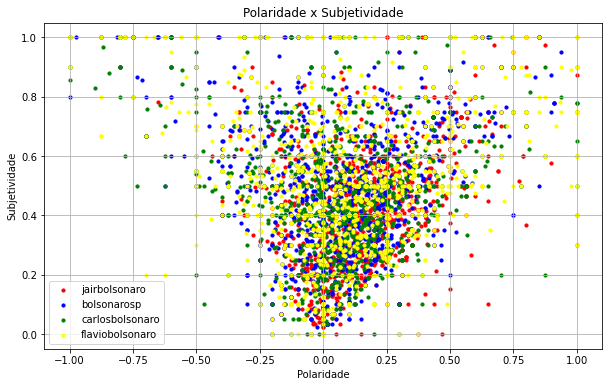

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax.set_title("Polaridade x Subjetividade")
for (name, color) in [("jairbolsonaro", "red"), ("bolsonarosp", "blue"),
             ("carlosbolsonaro", "green"), ("flaviobolsonaro", "yellow")]:
    ax.scatter(dfSent[dfSent.name == name].polarity, dfSent[dfSent.name == name].subjectivity, c = color, label = name, s = 10)
ax.set_xlabel("Polaridade")
ax.set_ylabel("Subjetividade")
plt.legend()
plt.grid()
plt.savefig('..//images//pol_subj_by_name.pdf')
plt.show()

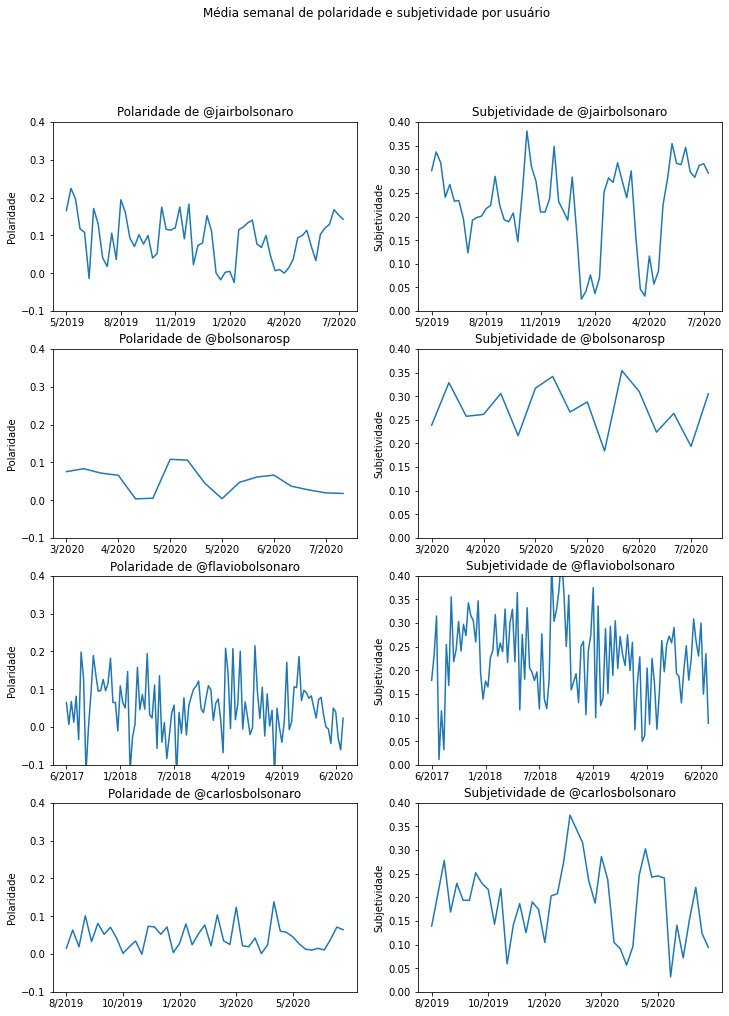

In [ ]:
plot_data = dfSent.groupby(by = ["name","year", "month", "day"]).mean()
plot_data.reset_index(inplace = True)
fig, axis = plt.subplots(nrows = 4, ncols = 2)
fig.set_figheight(16)
fig.set_figwidth(12)
plt.suptitle("Média semanal de polaridade e subjetividade por usuário")
name = ['jairbolsonaro', 'bolsonarosp', 'flaviobolsonaro', 'carlosbolsonaro']
for (i, row) in enumerate(axis):
    row_data = plot_data[plot_data.name == name[i]].rolling(7).mean().iloc[::7, :]
    row_data.dropna(inplace = True)
    date_ticks = row_data.month.map(lambda x : str(int(np.floor(x)))) + "/" + row_data.year.map(lambda x : str(int(x)))
    n_ticks = int(len(date_ticks)/5)
    row[0].set_title("Polaridade de @" + name[i])
    row[0].plot(row_data.index, row_data.polarity)
    row[0].set_ylabel("Polaridade")
    row[0].set_xticks(row_data.index[::n_ticks])
    row[0].set_xticklabels(date_ticks[::n_ticks])
    row[0].set_ylim((-0.1, 0.4))

    row[1].set_title("Subjetividade de @"+ name[i])
    row[1].plot(row_data.index, row_data.subjectivity)
    row[1].set_ylabel("Subjetividade")
    row[1].set_xticks(row_data.index[::n_ticks])
    row[1].set_xticklabels(date_ticks[::n_ticks])
    row[1].set_ylim((0.0, 0.4))
plt.savefig("..//images//pol_subj_by_time.pdf")
plt.show()

Nessa ultima visualização, vemos que a polaridade e subjetividade dos tweets não apresentam nenhum comportamento padronizado ao longo do tempo. Por fim, vamos observar alguns dos tweets mais polarizados e subjetivos encontrados.

Para a última visualização, iremos gerar duas nuvens de palavras, uma para os tweets com polaridade positiva e outra para os tweets com polaridade negativa.

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import nltk
stopwords = nltk.corpus.stopwords.words('portuguese')

def convert_tweets_to_text(df):
    df = df.full_text.str.lower() #everything lowercase
    df = df.str.replace('^https?:\/\/.*[\r\n]*', '', regex = True) #remove urls
    df = df.str.replace('[^A-zÀ-ú0-9 ]', '', regex = True) #keeps only alphanumerics and space 
    return "".join(df.tolist())


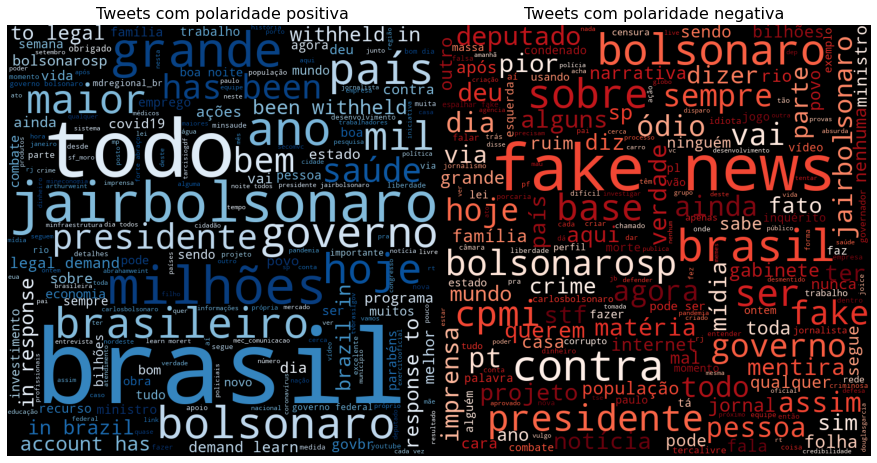

In [ ]:
tweets_positive = convert_tweets_to_text(dfFinal[dfFinal.polarity > 0.3])
tweets_negative = convert_tweets_to_text(dfFinal[dfFinal.polarity < -0.3])
wordcloud1 = WordCloud(width = 800, height = 800, background_color ='black', 
                      stopwords = stopwords, min_font_size = 10, colormap = "Blues").generate(tweets_positive) 
wordcloud2 = WordCloud(width = 800, height = 800, background_color ='black', 
                      stopwords = stopwords, min_font_size = 10, colormap = "Reds").generate(tweets_negative) 
# plot the WordCloud images               
fig = plt.figure(figsize = (12, 12), facecolor = None) 
#fig.tight_layout(rect=[0, 0.05, 1, 0.95])
ax1 = plt.subplot(121)
plt.imshow(wordcloud1)
plt.axis("off") 
ax1.set_title("Tweets com polaridade positiva",  fontsize=16)
ax2 = plt.subplot(122)
plt.imshow(wordcloud2) 
plt.axis("off") 
ax2.set_title("Tweets com polaridade negativa",  fontsize=16)
plt.tight_layout(pad = 0.05) 
plt.savefig('..//images//sentiment_wordcloud.pdf', pad_inches = 1)
plt.show() 

In [ ]:
dfSent = dfSent.sort_values('polarity')
for i in [0, 1, -2, -1]:
    if i == 0:
        print("Tweets com polaridade negativa:")
    elif i == -2:
        print()
        print("Tweets com polaridade positiva:")
    print("Usuário: " + dfSent.iloc[i, :]['name'] + " Data: " + str(dfSent.iloc[i, :].date))
    print("Tweet:" + dfSent.iloc[i, :].full_text)

dfSent = dfSent.sort_values('subjectivity', ascending = False)
print()
print("Tweets com subjetividade:")
for i in [0, 1]:
    print("Usuário: " + dfSent.iloc[i, :]['name'] + " Data: " + str(dfSent.iloc[i, :].date))
    print("Tweet:" + dfSent.iloc[i, :].full_text)

Tweets com polaridade negativa:
Usuário: carlosbolsonaro Data: 2020-03-16 00:23:19+00:00
Tweet:Não adianta pagar de porta-voz da nação. O povo o odeia! Não os representa. Saia da bolha, vá na rua e perceberá!
Usuário: flaviobolsonaro Data: 2017-09-18 11:10:10+00:00
Tweet:Legalizar a pedofilia é o objetivo desses imundos! https://t.co/KMLqb4g1Da

Tweets com polaridade positiva:
Usuário: jairbolsonaro Data: 2019-06-12 22:42:37+00:00
Tweet:Feliz dia dos namorados! 👍 https://t.co/e1svTppojj
Usuário: jairbolsonaro Data: 2020-07-27 20:51:13+00:00
Tweet:-Edifício Joelma/SP, 1974.

-Sgt CASSANIGA salta de helicóptero da FAB no terraço do edifício em chamas para salvar vidas, em uma das maiores tragédias na história do Brasil.

. Link no YouTube: https://t.co/JW8q4qN3a8 https://t.co/3Ulw3G96D5

Tweets com subjetividade:
Usuário: jairbolsonaro Data: 2020-07-27 20:51:13+00:00
Tweet:-Edifício Joelma/SP, 1974.

-Sgt CASSANIGA salta de helicóptero da FAB no terraço do edifício em chamas para salvar 